# Import Libraries

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning

# Ignore specific warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Current working directory
current_dir = os.getcwd()

# Define BASE_DIR
BASE_DIR = os.path.abspath(os.path.join(current_dir, '..'))

BASE_DIR

'd:\\AI Projects\\Lumpy Skin Disease Prediction'

In [4]:
IMAGE_DIR_PATH = Path(os.path.join(BASE_DIR, 'data', 'Lumpy_skin_image_dataset'))

filepaths = list(IMAGE_DIR_PATH.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Create DataFrame
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop=True)
image_df.head()

,Filepath,Label
0,d:\AI Projects\Lumpy Skin Disease Prediction\d...,Normal Skin
1,d:\AI Projects\Lumpy Skin Disease Prediction\d...,Normal Skin
2,d:\AI Projects\Lumpy Skin Disease Prediction\d...,Normal Skin
3,d:\AI Projects\Lumpy Skin Disease Prediction\d...,Normal Skin
4,d:\AI Projects\Lumpy Skin Disease Prediction\d...,Lumpy Skin


# Display Sample Images

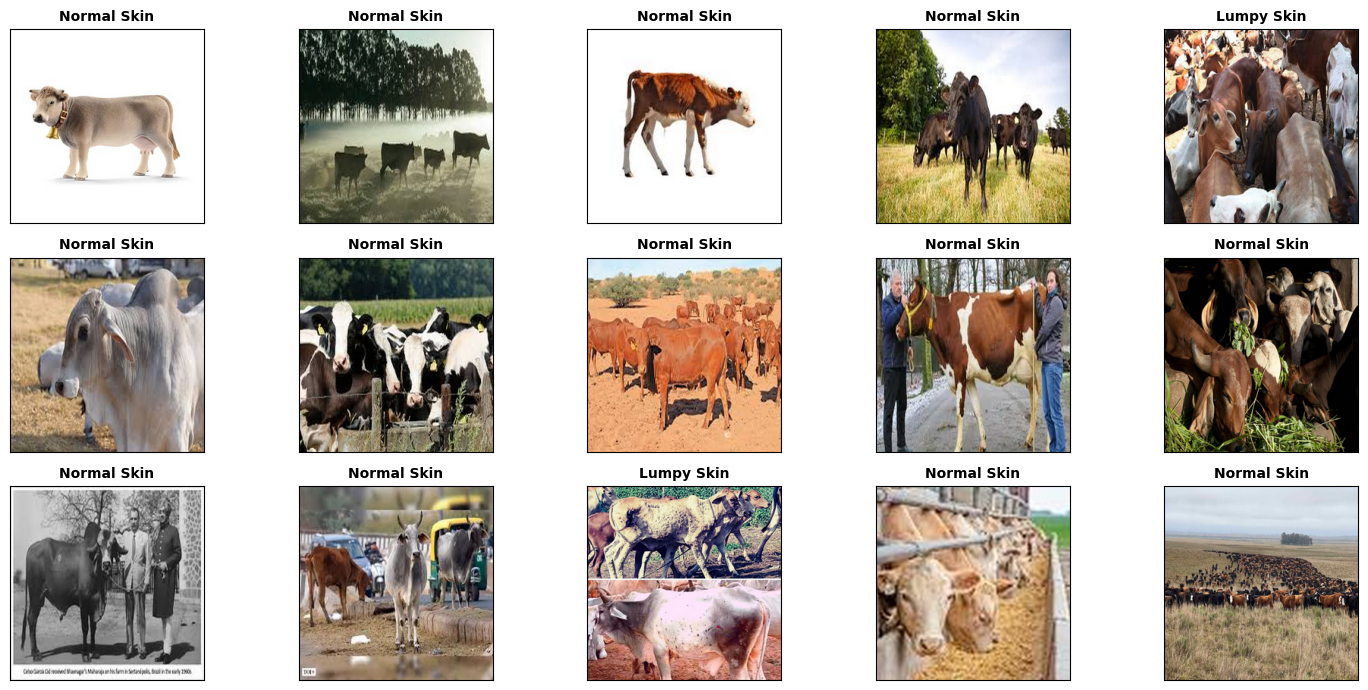

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    img = plt.imread(image_df.Filepath[i])
    ax.imshow(img)
    ax.set_title(image_df.Label[i], color='black', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

# Split data into training and testing sets

In [6]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)
print(f"Training samples: {len(train_df)}, Testing samples: {len(test_df)}")

Training samples: 921, Testing samples: 103


# Data Augmentation and Image Data Generators

In [7]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=180,
    fill_mode='nearest'
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 737 validated image filenames belonging to 2 classes.
Found 184 validated image filenames belonging to 2 classes.
Found 103 validated image filenames belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9975093..0.9671452].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RG

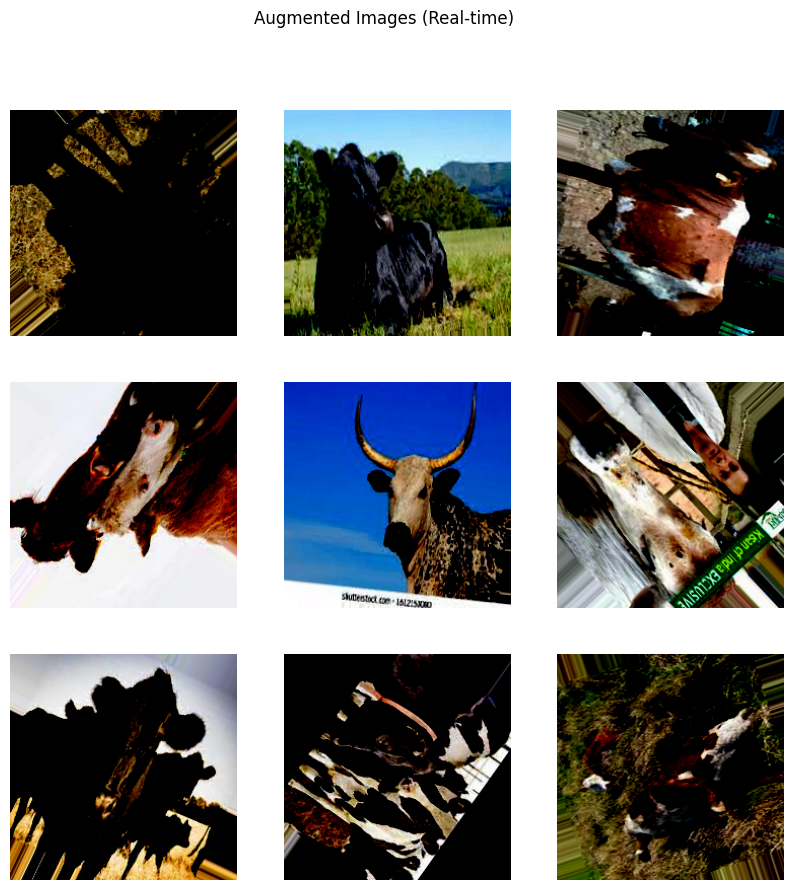

In [8]:
# Display a batch of augmented images from the training data generator
import matplotlib.pyplot as plt

# Get a batch of augmented images and labels from the training generator
augmented_images, labels = next(train_images)  # train_images is the training generator

# Display the first 9 images in the batch
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(augmented_images[i])
    ax.axis('off')
plt.suptitle("Augmented Images (Real-time)")
plt.show()


# Load Pre-Trained Model

In [20]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False  # Freeze base model

In [21]:
# Add custom layers on top
inputs = pretrained_model.input
x = tf.keras.layers.Dense(256, activation='selu')(pretrained_model.output)
x = tf.keras.layers.Dense(256, activation='selu')(x)
x = tf.keras.layers.Dense(128, activation='selu')(x)
x = tf.keras.layers.Dense(128, activation='selu')(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

# Train Model

In [22]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    # ]
)

Epoch 1/20
24/24 [==============================] - 26s 831ms/step - loss: 2.3935 - accuracy: 0.6038 - val_loss: 0.5685 - val_accuracy: 0.7065
Epoch 2/20
24/24 [==============================] - 18s 743ms/step - loss: 0.6451 - accuracy: 0.7001 - val_loss: 0.4333 - val_accuracy: 0.8478
Epoch 3/20
24/24 [==============================] - 25s 1s/step - loss: 0.6133 - accuracy: 0.7327 - val_loss: 0.4049 - val_accuracy: 0.7989
Epoch 4/20
24/24 [==============================] - 19s 808ms/step - loss: 0.4131 - accuracy: 0.8223 - val_loss: 0.4213 - val_accuracy: 0.7826
Epoch 5/20
24/24 [==============================] - 19s 785ms/step - loss: 0.3719 - accuracy: 0.8412 - val_loss: 0.3022 - val_accuracy: 0.8641
Epoch 6/20
24/24 [==============================] - 21s 880ms/step - loss: 0.4000 - accuracy: 0.8290 - val_loss: 0.3265 - val_accuracy: 0.8533
Epoch 7/20
24/24 [==============================] - 19s 761ms/step - loss: 1.0433 - accuracy: 0.6757 - val_loss: 0.7120 - val_accuracy: 0.6413
Ep

In [23]:
plots_dir = 'plots'
os.makedirs(plots_dir, exist_ok=True)

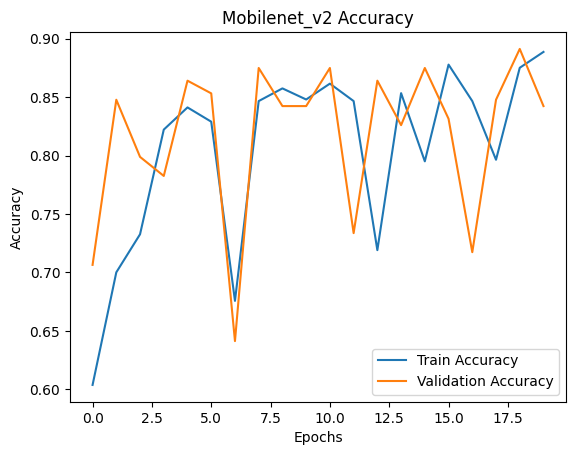

In [24]:
# Visualize and save Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Mobilenet_v2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(plots_dir, 'mobilenet_v2_train_val_accuracy.png'))  # Save the accuracy plot
plt.show()

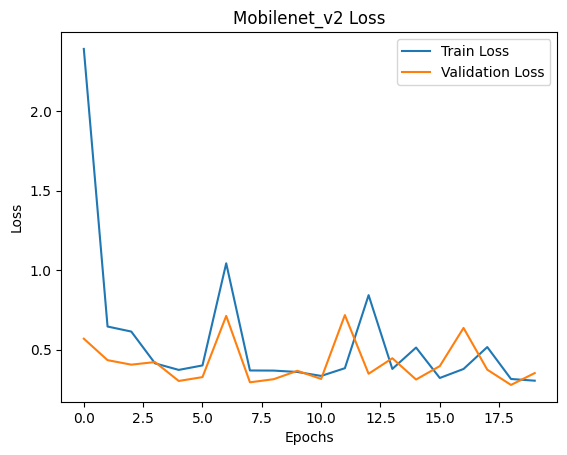

In [25]:
# Visualize and save Training and Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Mobilenet_v2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(plots_dir, 'mobilenet_v2_train_val_loss.png'))  # Save the loss plot
plt.show()

In [26]:
# Save the Model
models_dir = "models"
model_save_path = f"{models_dir}/mobilenet_lumpy_skin_model.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to models/mobilenet_lumpy_skin_model.h5


In [27]:
# Load the Saved Model for Testing
loaded_model = tf.keras.models.load_model(model_save_path)

# Evaluate Model Accuracy

In [28]:
# Evaluate on Train Set
train_loss, train_accuracy = loaded_model.evaluate(train_images)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

24/24 [==============================] - 15s 546ms/step - loss: 0.3743 - accuracy: 0.8589
Train Accuracy: 85.89%


In [29]:
# Evaluate on Test Set
test_loss, test_accuracy = loaded_model.evaluate(test_images)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

4/4 [==============================] - 1s 131ms/step - loss: 0.2901 - accuracy: 0.8738
Test Accuracy: 87.38%


# Function to Test Model on Individual Images

In [30]:
from keras_preprocessing import image
def predict_image(img_path, model, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    class_labels = list(test_images.class_indices.keys())
    print(f"Predicted class: {class_labels[predicted_class]}")

# Test the function with a sample image
sample_image_path = test_df['Filepath'].iloc[0]
predict_image(sample_image_path, loaded_model)


1/1 [==============================] - 2s 2s/step
Predicted class: Lumpy Skin
